# Final Term Machine Learning - Fish Image Dataset CNN
Alvito Kiflan Hawari (1103220235)

## **GPU Check**

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else None)
device = "cuda" if torch.cuda.is_available() else "cpu"


2.6.0+cu124
True
NVIDIA GeForce RTX 4060


mengecek apakah environment PyTorch mendeteksi GPU.

## **Load dataset + jumlah kelas (Preprocessing & Augmentation)**

In [2]:
import os, numpy as np
from torchvision import datasets, transforms

DATA_DIR = "../FishImgDataset"
IMG_SIZE = 224

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_tfms)
val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), transform=eval_tfms)
test_ds  = datasets.ImageFolder(os.path.join(DATA_DIR, "test"), transform=eval_tfms)

class_names = train_ds.classes
print("num_classes:", len(class_names))
print("classes:", class_names)


num_classes: 31
classes: ['Bangus', 'Big Head Carp', 'Black Spotted Barb', 'Catfish', 'Climbing Perch', 'Fourfinger Threadfin', 'Freshwater Eel', 'Glass Perchlet', 'Goby', 'Gold Fish', 'Gourami', 'Grass Carp', 'Green Spotted Puffer', 'Indian Carp', 'Indo-Pacific Tarpon', 'Jaguar Gapote', 'Janitor Fish', 'Knifefish', 'Long-Snouted Pipefish', 'Mosquito Fish', 'Mudfish', 'Mullet', 'Pangasius', 'Perch', 'Scat Fish', 'Silver Barb', 'Silver Carp', 'Silver Perch', 'Snakehead', 'Tenpounder', 'Tilapia']


Cell ini berfungsi menyiapkan *input data* untuk seluruh pipeline klasifikasi gambar.

- Menentukan lokasi dataset (`FishImgDataset`) dan menyamakan ukuran gambar menjadi **224×224** agar semua input konsisten.
- Membuat dua alur transformasi:
  - **Train transforms** berisi *data augmentation* (crop, flip, rotasi, perubahan warna) untuk meningkatkan variasi data dan mengurangi overfitting.
  - **Eval/Test transforms** hanya preprocessing (resize + normalize) agar evaluasi lebih adil dan stabil.
- Memuat dataset menjadi `train_ds`, `val_ds`, dan `test_ds` yang siap digunakan oleh PyTorch (`ImageFolder`).
- Mengambil daftar nama kelas (`class_names`) untuk menentukan **jumlah kelas output**, membuat **classification report**, **confusion matrix**, dan label pada visualisasi/Grad-CAM.


In [3]:
targets = np.array([y for _, y in train_ds.samples])
counts = np.bincount(targets)
print("min:", counts.min(), "max:", counts.max())


min: 110 max: 1222


## **Visualisasi Data Augmentation**

Saved: d:\CNN_FishImgDataset\outputs\figures\augmentation_grid.png


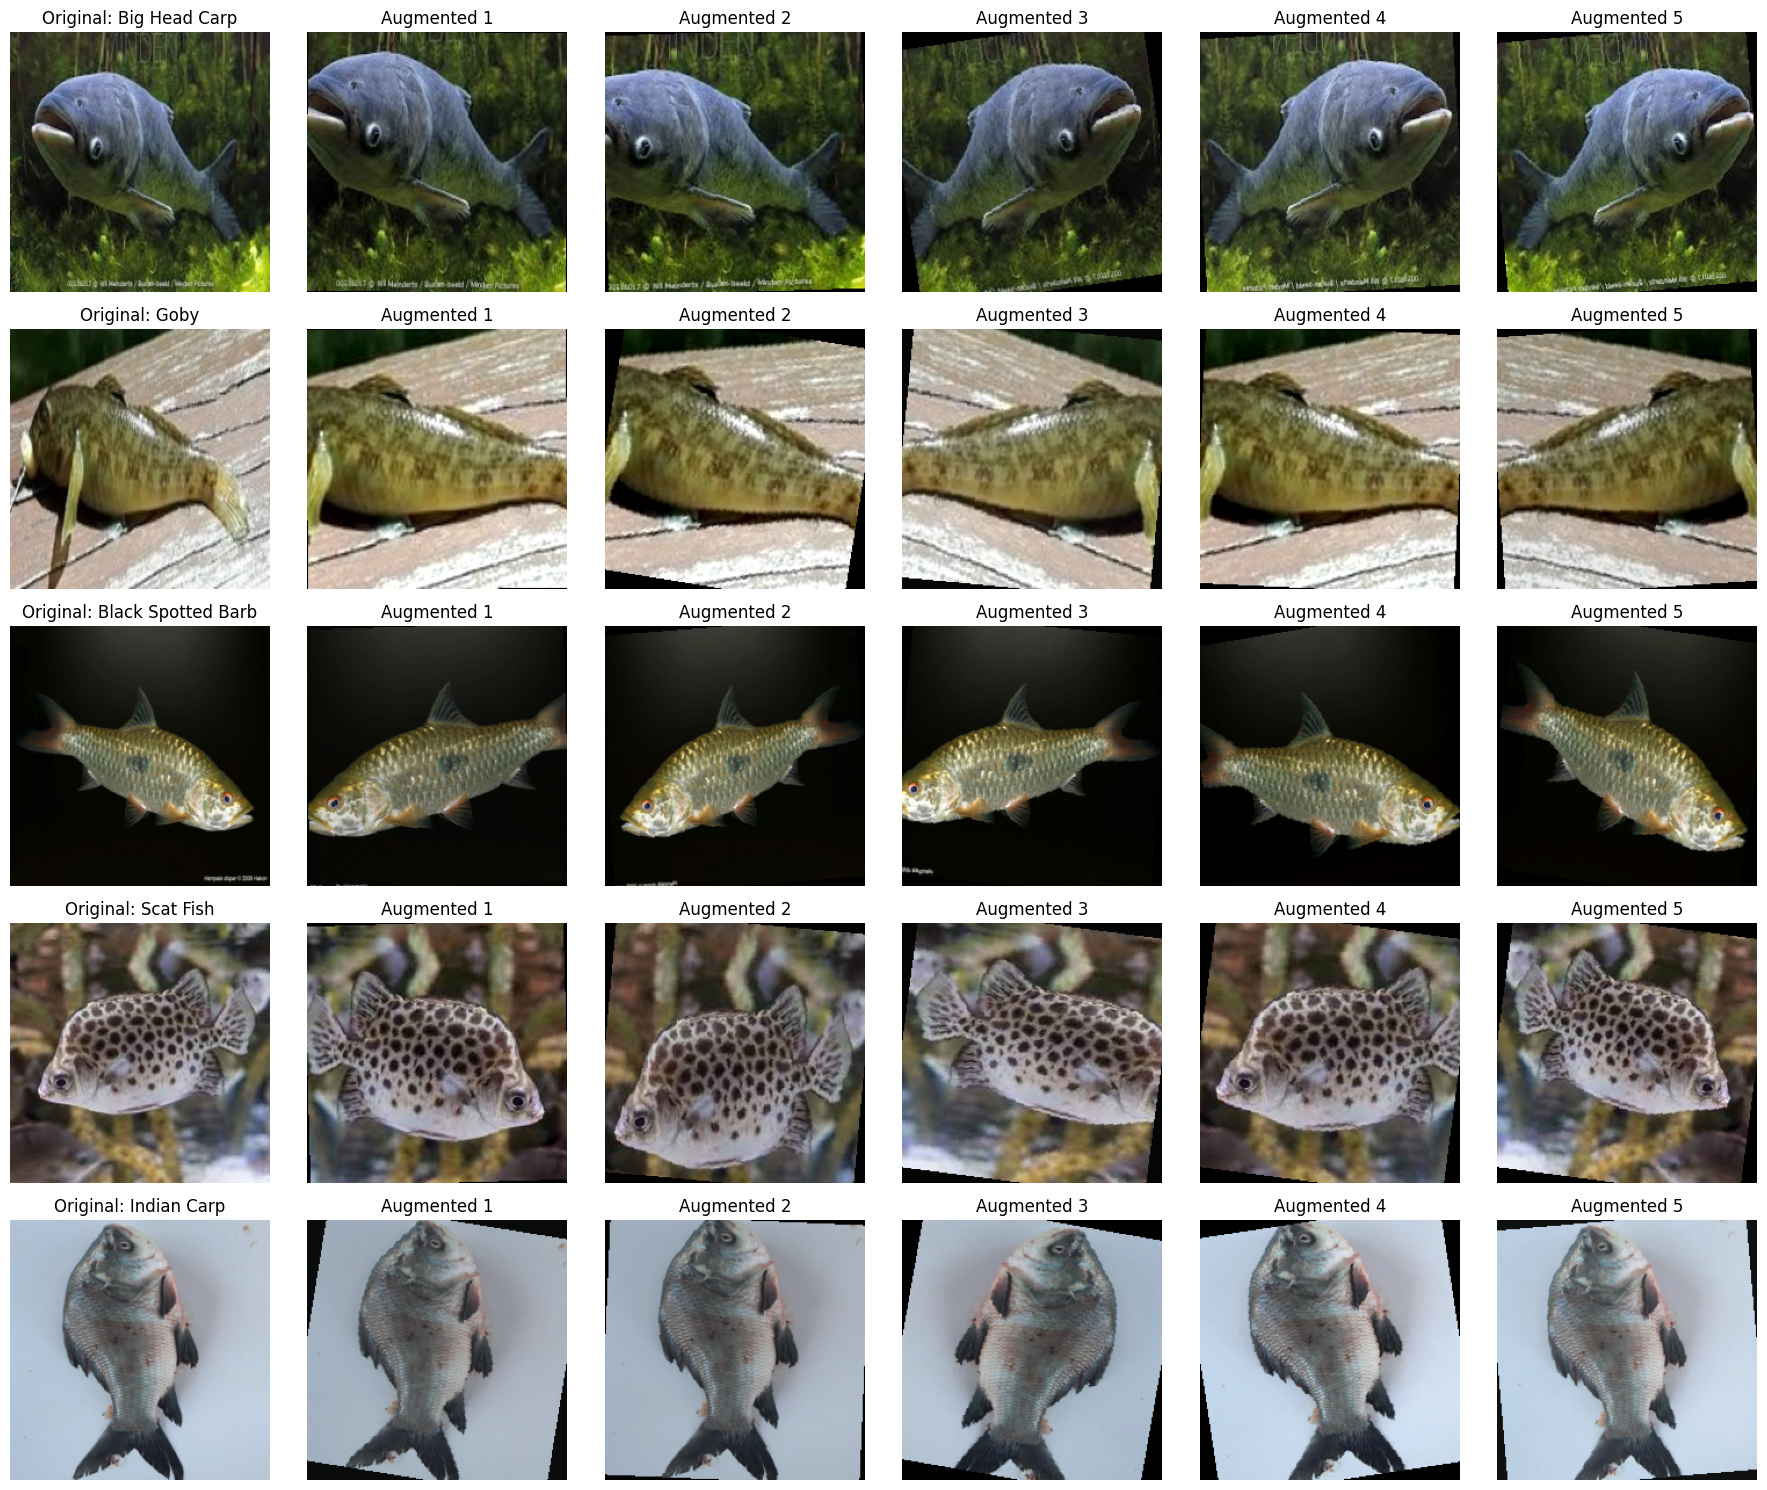

In [48]:
# === Cell: Data Augmentation Visualization + SAVE ke outputs/figures ===
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

os.makedirs("../outputs/figures", exist_ok=True)

# Helper: unnormalize biar gambar tampil normal
mean = np.array([0.485,0.456,0.406])
std  = np.array([0.229,0.224,0.225])

def show_aug_grid(dataset, class_names, n_classes=5, n_aug=5, seed=123,
                  save_path="../outputs/figures/augmentation_grid.png"):
    random.seed(seed)

    chosen_classes = random.sample(range(len(class_names)), k=min(n_classes, len(class_names)))

    plt.figure(figsize=(3*(n_aug+1), 3*n_classes))

    for row, cls in enumerate(chosen_classes):
        idxs = [i for i, (_, y) in enumerate(dataset.samples) if y == cls]
        idx = random.choice(idxs)
        img_path, label = dataset.samples[idx]

        img_pil = Image.open(img_path).convert("RGB")

        base_tfms = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist())
        ])
        orig = base_tfms(img_pil).permute(1,2,0).numpy()
        orig = np.clip(orig * std + mean, 0, 1)

        ax = plt.subplot(n_classes, n_aug+1, row*(n_aug+1) + 1)
        ax.imshow(orig)
        ax.set_title(f"Original: {class_names[label]}")
        ax.axis("off")

        for j in range(n_aug):
            aug_tensor, _ = dataset[idx]
            aug = aug_tensor.permute(1,2,0).numpy()
            aug = np.clip(aug * std + mean, 0, 1)

            ax = plt.subplot(n_classes, n_aug+1, row*(n_aug+1) + 2 + j)
            ax.imshow(aug)
            ax.set_title(f"Augmented {j+1}")
            ax.axis("off")

    plt.tight_layout()

    # ✅ save sebelum show
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    print("Saved:", os.path.abspath(save_path))

    plt.show()

# RUN
show_aug_grid(train_ds, class_names, n_classes=5, n_aug=5, save_path="../outputs/figures/augmentation_grid.png")


Cell ini digunakan untuk **memvisualisasikan hasil data augmentation** yang diterapkan pada dataset training.

- Menampilkan beberapa contoh gambar dari beberapa kelas secara acak.
- Untuk tiap kelas, ditampilkan **1 gambar original** dan beberapa versi **hasil augmentasi** (mis. crop, flip, rotasi, perubahan warna).
- Tujuannya untuk memastikan augmentasi yang dipakai memang bekerja dan menghasilkan variasi data yang realistis, sehingga model lebih robust dan tidak mudah overfitting.
- Hasil visualisasi disimpan sebagai file gambar ke folder: `outputs/figures/augmentation_grid.png` untuk dimasukkan ke laporan.


## **DataLoader + handle class imbalance (WeightedRandomSampler)**

In [4]:
from torch.utils.data import DataLoader, WeightedRandomSampler

BATCH_SIZE = 32
NUM_WORKERS = 4

targets = np.array([y for _, y in train_ds.samples])
class_counts = np.bincount(targets)
class_weights = 1.0 / np.maximum(class_counts, 1)
sample_weights = class_weights[targets]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

print("train batches:", len(train_loader), "val batches:", len(val_loader), "test batches:", len(test_loader))


train batches: 276 val batches: 86 test batches: 55


Cell ini menyiapkan **DataLoader** untuk proses training/validasi/test sekaligus menangani **ketidakseimbangan jumlah data antar kelas (class imbalance)**.

- Menghitung jumlah sampel per kelas pada data training, lalu membuat bobot sehingga **kelas yang jarang muncul** mendapatkan peluang sampling lebih besar.
- Menggunakan **WeightedRandomSampler** agar setiap batch training lebih “seimbang” (minor class lebih sering ikut terlatih), sehingga model tidak bias hanya ke kelas mayoritas.
- Membuat `train_loader`, `val_loader`, dan `test_loader` yang akan dipakai oleh semua eksperimen berikutnya (CNN scratch, MobileNetV2 head, fine-tuning).
- Menampilkan jumlah batch untuk memastikan loader sudah terbentuk dengan benar.


## **CNN from scratch (baseline)**

In [5]:
import torch.nn as nn

class SimpleFishCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

scratch_model = SimpleFishCNN(num_classes=len(class_names)).to(device)


Cell ini membangun **model CNN sederhana dari nol (tanpa pretrained)** sebagai **baseline** untuk pembanding.

- Tujuannya adalah melihat performa CNN buatan sendiri pada dataset ikan, sebelum memakai transfer learning.
- Arsitektur terdiri dari beberapa blok ekstraksi fitur (convolution + aktivasi + pooling) untuk menangkap pola visual penting pada gambar ikan.
- Di bagian akhir, fitur yang sudah diekstrak diubah menjadi prediksi kelas melalui classifier.
- Model ini akan dilatih pada cell berikutnya dan hasilnya dibandingkan dengan model pretrained (MobileNetV2) untuk membuktikan manfaat transfer learning.


## **Training loop (dipakai untuk scratch dan MobileNetV2)**

In [6]:
import torch
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

def train_one_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=(device=="cuda")):
            logits = model(x)
            loss = criterion(logits, y)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)

    return total_loss/total, correct/total

@torch.no_grad()
def eval_one_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for x, y in tqdm(loader, leave=False):
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(1) == y).sum().item()
        total += x.size(0)
    return total_loss/total, correct/total


Cell ini menyiapkan **fungsi training dan evaluasi per-epoch** yang akan dipakai ulang untuk semua model (CNN scratch, MobileNetV2 head, dan fine-tuning).

- Menstandarkan proses training agar perbandingan antar model **fair** (semua model dilatih dan dievaluasi dengan cara yang sama).
- Menghasilkan metrik utama setiap epoch: **loss** dan **accuracy** untuk data training dan validation.
- Memisahkan alur **training** (update parameter model) dan **evaluation** (mengukur performa tanpa update parameter).


## **Train scratch CNN**

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(scratch_model.parameters(), lr=1e-3, weight_decay=1e-4)
scaler = GradScaler(enabled=(device=="cuda"))

scratch_hist = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

for epoch in range(50):
    tr_loss, tr_acc = train_one_epoch(scratch_model, train_loader, optimizer, criterion, scaler)
    va_loss, va_acc = eval_one_epoch(scratch_model, val_loader, criterion)
    scratch_hist["train_loss"].append(tr_loss); scratch_hist["train_acc"].append(tr_acc)
    scratch_hist["val_loss"].append(va_loss); scratch_hist["val_acc"].append(va_acc)
    print(f"[Scratch] Epoch {epoch+1} | train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f}")


C:\Users\Alvaro\AppData\Local\Temp\ipykernel_3992\2991989522.py:3: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device=="cuda"))
  0%|          | 0/276 [00:00<?, ?it/s]C:\Users\Alvaro\AppData\Local\Temp\ipykernel_3992\3604794530.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device=="cuda")):


[Scratch] Epoch 1 | train 3.0629/0.1562 | val 2.9189/0.1618


[Scratch] Epoch 2 | train 2.8931/0.1878 | val 2.9023/0.1865


[Scratch] Epoch 3 | train 2.8123/0.2042 | val 2.8546/0.2028


[Scratch] Epoch 4 | train 2.7403/0.2246 | val 2.7185/0.2377


[Scratch] Epoch 5 | train 2.6993/0.2411 | val 2.6467/0.2392


[Scratch] Epoch 6 | train 2.6296/0.2591 | val 2.6337/0.2577


[Scratch] Epoch 7 | train 2.5986/0.2657 | val 2.5183/0.2843


[Scratch] Epoch 8 | train 2.5518/0.2717 | val 2.5240/0.2759


[Scratch] Epoch 9 | train 2.5148/0.2881 | val 2.4495/0.2988


[Scratch] Epoch 10 | train 2.4776/0.2984 | val 2.4470/0.2937


[Scratch] Epoch 11 | train 2.4464/0.3007 | val 2.4521/0.3006


[Scratch] Epoch 12 | train 2.4343/0.3110 | val 2.4147/0.3093


[Scratch] Epoch 13 | train 2.4053/0.3184 | val 2.3964/0.3395


[Scratch] Epoch 14 | train 2.3486/0.3353 | val 2.3564/0.3362


[Scratch] Epoch 15 | train 2.3560/0.3315 | val 2.3525/0.3475


[Scratch] Epoch 16 | train 2.3479/0.3303 | val 2.3443/0.3479


[Scratch] Epoch 17 | train 2.3252/0.3397 | val 2.2916/0.3530


[Scratch] Epoch 18 | train 2.2779/0.3535 | val 2.3000/0.3675


[Scratch] Epoch 19 | train 2.2721/0.3431 | val 2.3097/0.3421


[Scratch] Epoch 20 | train 2.2383/0.3579 | val 2.2636/0.3704


[Scratch] Epoch 21 | train 2.2471/0.3562 | val 2.2769/0.3559


[Scratch] Epoch 22 | train 2.2308/0.3627 | val 2.2117/0.3882


[Scratch] Epoch 23 | train 2.2277/0.3689 | val 2.2674/0.3515


[Scratch] Epoch 24 | train 2.1951/0.3754 | val 2.2592/0.3810


[Scratch] Epoch 25 | train 2.1701/0.3746 | val 2.2937/0.3468


[Scratch] Epoch 26 | train 2.1677/0.3836 | val 2.2300/0.3784


[Scratch] Epoch 27 | train 2.1545/0.3859 | val 2.2051/0.3966


[Scratch] Epoch 28 | train 2.1524/0.3875 | val 2.1895/0.3908


[Scratch] Epoch 29 | train 2.1377/0.3877 | val 2.2407/0.3370


[Scratch] Epoch 30 | train 2.1037/0.3948 | val 2.1780/0.3864


[Scratch] Epoch 31 | train 2.1385/0.3898 | val 2.0444/0.4311


[Scratch] Epoch 32 | train 2.0848/0.4022 | val 2.0912/0.3915


[Scratch] Epoch 33 | train 2.0602/0.4066 | val 2.1109/0.4133


[Scratch] Epoch 34 | train 2.0924/0.3936 | val 2.1148/0.4017


[Scratch] Epoch 35 | train 2.0615/0.4019 | val 2.0953/0.4238


[Scratch] Epoch 36 | train 2.0551/0.4102 | val 2.1229/0.3919


[Scratch] Epoch 37 | train 2.0627/0.4068 | val 2.1141/0.4166


[Scratch] Epoch 38 | train 2.0217/0.4168 | val 2.0065/0.4260


[Scratch] Epoch 39 | train 2.0105/0.4247 | val 2.0343/0.4017


[Scratch] Epoch 40 | train 2.0157/0.4221 | val 2.1137/0.3893


[Scratch] Epoch 41 | train 2.0041/0.4217 | val 2.0123/0.4180


[Scratch] Epoch 42 | train 2.0011/0.4238 | val 2.0890/0.4089


[Scratch] Epoch 43 | train 2.0039/0.4250 | val 2.0565/0.3937


[Scratch] Epoch 44 | train 1.9969/0.4274 | val 2.0986/0.4002


[Scratch] Epoch 45 | train 1.9521/0.4405 | val 1.9770/0.4366


[Scratch] Epoch 46 | train 1.9594/0.4363 | val 2.0182/0.4315


[Scratch] Epoch 47 | train 1.9529/0.4402 | val 1.9356/0.4537


[Scratch] Epoch 48 | train 1.9586/0.4363 | val 2.0277/0.4206


[Scratch] Epoch 49 | train 1.9566/0.4319 | val 1.9972/0.4180


[Scratch] Epoch 50 | train 1.9340/0.4455 | val 2.0070/0.4104


Cell ini menjalankan **proses training model CNN dari nol** sebagai baseline.
- Melatih `scratch_model` menggunakan data training dan mengevaluasi performanya pada data validasi selama beberapa epoch.
- Mencatat metrik penting setiap epoch (**train loss/accuracy** dan **val loss/accuracy**) ke dalam `scratch_hist` untuk kebutuhan analisis dan plot kurva training.
- Menampilkan progres training per epoch sehingga kita bisa melihat apakah model belajar dengan baik atau mengalami overfitting/underfitting.
- Hasil baseline ini digunakan sebagai **pembanding utama** untuk menunjukkan bahwa transfer learning (MobileNetV2) memberikan performa yang lebih baik dan training yang lebih stabil.

In [8]:
i = len(scratch_hist["val_loss"]) - 1
print(
    f"CNN Scratch | epoch: {i+1:02d} "
    f"| train_loss: {scratch_hist['train_loss'][i]:.6f} | train_acc: {scratch_hist['train_acc'][i]:.6f} "
    f"| val_loss: {scratch_hist['val_loss'][i]:.6f} | val_acc: {scratch_hist['val_acc'][i]:.6f}"
)


CNN Scratch | epoch: 50 | train_loss: 1.934035 | train_acc: 0.445530 | val_loss: 2.006969 | val_acc: 0.410396


Menampilkan hasil epoch terakhir

## **Reset GPU memory**

In [9]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()


membersihkan VRAM sebelum menlanjutkan training lagi

## **MobileNetV2 pretrained + freeze backbone**

In [10]:
from torchvision import models

mobilenet = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
mobilenet.classifier[1] = nn.Linear(mobilenet.last_channel, len(class_names))
mobilenet = mobilenet.to(device)

for p in mobilenet.features.parameters():
    p.requires_grad = False


Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\Alvaro/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 10.6MB/s]


Cell ini menyiapkan model **MobileNetV2 pretrained** untuk transfer learning dengan strategi **feature extractor**.
- Menggunakan bobot pretrained (dilatih dari dataset besar) agar model sudah punya kemampuan mengenali pola visual umum.
- Mengganti layer classifier terakhir agar outputnya sesuai dengan **jumlah kelas ikan** pada dataset ini.
- Membekukan (freeze) backbone/feature extractor sehingga pada tahap awal training hanya bagian “head/classifier” yang dilatih.
- Tujuannya: mendapatkan peningkatan akurasi lebih cepat dan stabil dibanding CNN scratch, serta mengurangi risiko overfitting saat data tidak terlalu besar.


## **Cek trainable params**

In [11]:
trainable = sum(p.numel() for p in mobilenet.parameters() if p.requires_grad)
total = sum(p.numel() for p in mobilenet.parameters())
print("trainable/total:", trainable, "/", total)


trainable/total: 39711 / 2263583


Cell ini digunakan untuk **memverifikasi** bahwa proses freeze backbone sudah benar.
- Menghitung jumlah parameter yang **ikut dilatih (trainable)** dibanding total parameter model.
- Jika backbone benar-benar freeze, maka jumlah trainable harus jauh lebih kecil (hanya classifier/head saja).
- Ini penting untuk memastikan eksperimen sesuai desain: *tahap 1 hanya melatih head* sebelum masuk ke fine-tuning.


## **MobileNetV2 pretrained + freeze backbone**
Cell ini menjalankan proses training

In [12]:
import os
os.makedirs("../outputs/checkpoints", exist_ok=True)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(mobilenet.parameters(), lr=1e-3, weight_decay=1e-4)
scaler = GradScaler(enabled=(device=="cuda"))

mb_hist1 = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
best_val = 1e9

for epoch in range(50):
    tr_loss, tr_acc = train_one_epoch(mobilenet, train_loader, optimizer, criterion, scaler)
    va_loss, va_acc = eval_one_epoch(mobilenet, val_loader, criterion)
    mb_hist1["train_loss"].append(tr_loss); mb_hist1["train_acc"].append(tr_acc)
    mb_hist1["val_loss"].append(va_loss); mb_hist1["val_acc"].append(va_acc)
    print(f"[MB Head] Epoch {epoch+1} | train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f}")

    if va_loss < best_val:
        best_val = va_loss
        torch.save(mobilenet.state_dict(), "../outputs/checkpoints/mobilenetv2_best.pt")
        print("Saved best.")


C:\Users\Alvaro\AppData\Local\Temp\ipykernel_3992\1484474326.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device=="cuda"))
  0%|          | 0/276 [00:00<?, ?it/s]C:\Users\Alvaro\AppData\Local\Temp\ipykernel_3992\3604794530.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device=="cuda")):


[MB Head] Epoch 1 | train 1.9184/0.5758 | val 1.3788/0.6932
Saved best.


[MB Head] Epoch 2 | train 1.0770/0.7387 | val 0.9946/0.7637
Saved best.


[MB Head] Epoch 3 | train 0.8892/0.7745 | val 0.8729/0.7870
Saved best.


[MB Head] Epoch 4 | train 0.7766/0.7959 | val 0.7852/0.8041
Saved best.


[MB Head] Epoch 5 | train 0.7068/0.8130 | val 0.7311/0.8099
Saved best.


[MB Head] Epoch 6 | train 0.6554/0.8220 | val 0.6960/0.8161
Saved best.


[MB Head] Epoch 7 | train 0.6406/0.8189 | val 0.6325/0.8342
Saved best.


[MB Head] Epoch 8 | train 0.6046/0.8260 | val 0.6080/0.8441
Saved best.


[MB Head] Epoch 9 | train 0.5890/0.8338 | val 0.5719/0.8477
Saved best.


[MB Head] Epoch 10 | train 0.5528/0.8420 | val 0.5839/0.8422


[MB Head] Epoch 11 | train 0.5303/0.8510 | val 0.5828/0.8328


[MB Head] Epoch 12 | train 0.5065/0.8561 | val 0.5618/0.8477
Saved best.


[MB Head] Epoch 13 | train 0.4882/0.8579 | val 0.5716/0.8393


[MB Head] Epoch 14 | train 0.4985/0.8537 | val 0.5123/0.8546
Saved best.


[MB Head] Epoch 15 | train 0.4626/0.8632 | val 0.5345/0.8535


[MB Head] Epoch 16 | train 0.4627/0.8627 | val 0.5112/0.8601
Saved best.


[MB Head] Epoch 17 | train 0.4464/0.8678 | val 0.4892/0.8659
Saved best.


[MB Head] Epoch 18 | train 0.4597/0.8602 | val 0.4836/0.8651
Saved best.


[MB Head] Epoch 19 | train 0.4213/0.8758 | val 0.4674/0.8659
Saved best.


[MB Head] Epoch 20 | train 0.4391/0.8646 | val 0.5060/0.8575


[MB Head] Epoch 21 | train 0.4438/0.8643 | val 0.4967/0.8561


[MB Head] Epoch 22 | train 0.4292/0.8739 | val 0.4502/0.8739
Saved best.


[MB Head] Epoch 23 | train 0.4020/0.8798 | val 0.4378/0.8782
Saved best.


[MB Head] Epoch 24 | train 0.4130/0.8737 | val 0.4588/0.8764


[MB Head] Epoch 25 | train 0.3982/0.8766 | val 0.4281/0.8822
Saved best.


[MB Head] Epoch 26 | train 0.3947/0.8783 | val 0.4577/0.8750


[MB Head] Epoch 27 | train 0.4055/0.8762 | val 0.4815/0.8579


[MB Head] Epoch 28 | train 0.3806/0.8833 | val 0.4508/0.8717


[MB Head] Epoch 29 | train 0.4006/0.8757 | val 0.4169/0.8815
Saved best.


[MB Head] Epoch 30 | train 0.4082/0.8762 | val 0.4209/0.8830


[MB Head] Epoch 31 | train 0.4075/0.8714 | val 0.4272/0.8804


[MB Head] Epoch 32 | train 0.3795/0.8830 | val 0.4343/0.8779


[MB Head] Epoch 33 | train 0.3859/0.8767 | val 0.4326/0.8746


[MB Head] Epoch 34 | train 0.3857/0.8803 | val 0.4475/0.8702


[MB Head] Epoch 35 | train 0.3908/0.8825 | val 0.4235/0.8764


[MB Head] Epoch 36 | train 0.3840/0.8809 | val 0.3854/0.8862
Saved best.


[MB Head] Epoch 37 | train 0.3856/0.8815 | val 0.4280/0.8790


[MB Head] Epoch 38 | train 0.3796/0.8815 | val 0.4266/0.8786


[MB Head] Epoch 39 | train 0.3831/0.8808 | val 0.4109/0.8851


[MB Head] Epoch 40 | train 0.3648/0.8830 | val 0.4261/0.8848


[MB Head] Epoch 41 | train 0.3778/0.8840 | val 0.3998/0.8877


[MB Head] Epoch 42 | train 0.3775/0.8795 | val 0.4180/0.8815


[MB Head] Epoch 43 | train 0.3727/0.8798 | val 0.4032/0.8833


[MB Head] Epoch 44 | train 0.3628/0.8888 | val 0.4009/0.8870


[MB Head] Epoch 45 | train 0.3585/0.8838 | val 0.3851/0.8924
Saved best.


[MB Head] Epoch 46 | train 0.3515/0.8958 | val 0.3897/0.8873


[MB Head] Epoch 47 | train 0.3501/0.8905 | val 0.3907/0.8840


[MB Head] Epoch 48 | train 0.3764/0.8809 | val 0.3985/0.8884


[MB Head] Epoch 49 | train 0.3627/0.8857 | val 0.3950/0.8800


[MB Head] Epoch 50 | train 0.3649/0.8849 | val 0.4097/0.8830


Dari log training terlihat bahwa model MobileNetV2 (backbone di-freeze, hanya head yang dilatih) belajar dengan baik dan cepat meningkatkan performa:

- Pada awal training (Epoch 1), akurasi validasi masih sekitar **0.69** dengan loss validasi **~1.38**.
- Seiring bertambahnya epoch, **val_loss turun stabil** (dari ~1.38 menjadi sekitar **0.38–0.41**) dan **val_acc naik stabil**.
- Model mencapai performa terbaik sekitar **Epoch 45** dengan **val_acc ≈ 0.8924 (89.24%)** dan **val_loss ≈ 0.3851**.
- Setelah itu, performa validasi cenderung **stagnan/naik-turun kecil** (contoh Epoch 50 val_acc ≈ 0.8830), menandakan model sudah mendekati batas kemampuan saat backbone masih dibekukan.

Kesimpulan: **train head-only sudah cukup bagus** (val_acc ~89%). Tahap berikutnya (fine-tuning) dilakukan untuk mencoba meningkatkan performa lebih lanjut dengan membuka sebagian layer backbone.


In [14]:
j = len(mb_hist1["val_loss"]) - 1
print(
    f"MobileNetV2 Head | epoch: {j+1:02d} "
    f"| train_loss: {mb_hist1['train_loss'][j]:.6f} | train_acc: {mb_hist1['train_acc'][j]:.6f}"
    f" | val_loss: {mb_hist1['val_loss'][j]:.6f} | val_acc: {mb_hist1['val_acc'][j]:.6f}"
)


MobileNetV2 Head | epoch: 50 | train_loss: 0.364937 | train_acc: 0.884926 | val_loss: 0.409748 | val_acc: 0.882952


Menampilkan hasil training Epoch terakhir 

## **Perbandingan Training Sractch dan MobileNetV2 Head**

In [15]:
i = len(scratch_hist["val_acc"]) - 1
j = len(mb_hist1["val_acc"]) - 1
print(f"SUMMARY | Scratch val_acc={scratch_hist['val_acc'][i]:.4f} | MobileNetV2 Head val_acc={mb_hist1['val_acc'][j]:.4f}")


SUMMARY | Scratch val_acc=0.4104 | MobileNetV2 Head val_acc=0.8830


Output ini menunjukkan perbandingan akurasi validasi antara:
- **CNN Scratch (baseline)**: `val_acc = 0.4104` (≈41.0%)
- **MobileNetV2 Head (transfer learning, backbone freeze)**: `val_acc = 0.8830` (≈88.3%)

Kesimpulan: transfer learning menggunakan MobileNetV2 memberikan peningkatan performa yang sangat signifikan dibanding CNN dari nol. Ini membuktikan bahwa fitur pretrained jauh lebih efektif untuk klasifikasi gambar pada dataset ini.

### **Load best checkpoint**

In [16]:
import torch
mobilenet.load_state_dict(torch.load("../outputs/checkpoints/mobilenetv2_best.pt", map_location=device))
print("Loaded best head checkpoint.")


Loaded best head checkpoint.


## **Fine-tuning**

In [17]:
# unfreeze 2 blok terakhir agar lebih stabil daripada unfreeze semua
for p in mobilenet.features[:-2].parameters():
    p.requires_grad = False
for p in mobilenet.features[-2:].parameters():
    p.requires_grad = True

trainable = sum(p.numel() for p in mobilenet.parameters() if p.requires_grad)
total = sum(p.numel() for p in mobilenet.parameters())
print("trainable/total:", trainable, "/", total)


trainable/total: 925791 / 2263583


Output `trainable/total: 925791 / 2263583` menunjukkan bahwa pada tahap **fine-tuning**, model tidak lagi hanya melatih head saja.

- **Trainable (925,791 parameter)** = jumlah parameter yang *ikut di-update* selama training fine-tune.
- **Total (2,263,583 parameter)** = total seluruh parameter MobileNetV2 + classifier.
- Karena hanya **unfreeze 2 blok terakhir** di backbone, maka yang dilatih adalah:
  1) classifier/head, dan  
  2) sebagian kecil layer backbone (2 blok terakhir)

Kesimpulan: fine-tuning yang dilatih adalah **bagian akhir backbone** (untuk adaptasi fitur ke dataset ikan) tanpa membuka semua layer, sehingga training lebih stabil dan risiko overfitting lebih kecil.


## **Train fine-tune**

In [18]:
import torch.nn as nn
from torch.amp import GradScaler

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(
    (p for p in mobilenet.parameters() if p.requires_grad),
    lr=1e-5, weight_decay=1e-4
)

scaler = GradScaler("cuda") if device=="cuda" else GradScaler()

mb_hist2 = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}
best_val_ft = 1e9

for epoch in range(25):
    tr_loss, tr_acc = train_one_epoch(mobilenet, train_loader, optimizer, criterion, scaler)
    va_loss, va_acc = eval_one_epoch(mobilenet, val_loader, criterion)

    mb_hist2["train_loss"].append(tr_loss); mb_hist2["train_acc"].append(tr_acc)
    mb_hist2["val_loss"].append(va_loss); mb_hist2["val_acc"].append(va_acc)

    print(f"[MB FT] Epoch {epoch+1} | train {tr_loss:.4f}/{tr_acc:.4f} | val {va_loss:.4f}/{va_acc:.4f}")

    if va_loss < best_val_ft:
        best_val_ft = va_loss
        torch.save(mobilenet.state_dict(), "../outputs/checkpoints/mobilenetv2_finetune_best.pt")
        print("Saved best fine-tune.")


  0%|          | 0/276 [00:00<?, ?it/s]C:\Users\Alvaro\AppData\Local\Temp\ipykernel_3992\3604794530.py:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device=="cuda")):


[MB FT] Epoch 1 | train 0.3381/0.8982 | val 0.3793/0.8920
Saved best fine-tune.


[MB FT] Epoch 2 | train 0.3377/0.8953 | val 0.3679/0.8979
Saved best fine-tune.


[MB FT] Epoch 3 | train 0.3018/0.9086 | val 0.3633/0.8949
Saved best fine-tune.


[MB FT] Epoch 4 | train 0.3180/0.8988 | val 0.3650/0.8982


[MB FT] Epoch 5 | train 0.3195/0.8995 | val 0.3520/0.9033
Saved best fine-tune.


[MB FT] Epoch 6 | train 0.3009/0.9088 | val 0.3626/0.8949


[MB FT] Epoch 7 | train 0.3023/0.9056 | val 0.3372/0.9008
Saved best fine-tune.


[MB FT] Epoch 8 | train 0.2927/0.9063 | val 0.3376/0.9040


[MB FT] Epoch 9 | train 0.2774/0.9138 | val 0.3365/0.9044
Saved best fine-tune.


[MB FT] Epoch 10 | train 0.2646/0.9167 | val 0.3268/0.9113
Saved best fine-tune.


[MB FT] Epoch 11 | train 0.2815/0.9075 | val 0.3197/0.9099
Saved best fine-tune.


[MB FT] Epoch 12 | train 0.2528/0.9222 | val 0.3291/0.9091


[MB FT] Epoch 13 | train 0.2459/0.9250 | val 0.3224/0.9109


[MB FT] Epoch 14 | train 0.2437/0.9225 | val 0.3182/0.9095
Saved best fine-tune.


[MB FT] Epoch 15 | train 0.2556/0.9184 | val 0.3255/0.9095


[MB FT] Epoch 16 | train 0.2583/0.9184 | val 0.3429/0.9026


[MB FT] Epoch 17 | train 0.2285/0.9259 | val 0.2995/0.9153
Saved best fine-tune.


[MB FT] Epoch 18 | train 0.2256/0.9274 | val 0.3064/0.9146


[MB FT] Epoch 19 | train 0.2430/0.9223 | val 0.3119/0.9149


[MB FT] Epoch 20 | train 0.2304/0.9271 | val 0.2784/0.9215
Saved best fine-tune.


[MB FT] Epoch 21 | train 0.2219/0.9305 | val 0.2995/0.9157


[MB FT] Epoch 22 | train 0.2254/0.9287 | val 0.2970/0.9149


[MB FT] Epoch 23 | train 0.2173/0.9325 | val 0.2849/0.9204


[MB FT] Epoch 24 | train 0.2084/0.9335 | val 0.2789/0.9233


[MB FT] Epoch 25 | train 0.2122/0.9351 | val 0.2846/0.9255


Log ini menunjukkan proses **fine-tuning** (sebagian layer backbone dibuka) berjalan baik dan memberikan peningkatan performa dibanding tahap head-only.

- Akurasi validasi awal fine-tune sudah tinggi (**~0.892** di Epoch 1) karena model memulai dari checkpoint pretrained + head yang sudah terlatih.
- Seiring epoch bertambah, **val_loss turun** dan **val_acc naik** secara bertahap hingga mencapai performa terbaik di akhir training.
- Performa validasi terbaik pada log ini adalah sekitar **val_acc = 0.9255 (92.55%)** di **Epoch 25**, dengan **val_loss ~0.2846**.
- Tulisan **“Saved best fine-tune.”** muncul saat **val_loss lebih kecil** dari sebelumnya, artinya model checkpoint diperbarui karena performa validasi membaik.

Kesimpulan: fine-tuning berhasil meningkatkan akurasi validasi dari sekitar **88–89% (head-only)** menjadi sekitar **92–93%**, sehingga unfreeze sebagian layer backbone efektif.


### **Hasil MobileNetV2 Fine-tune terakhir**

In [20]:
k = len(mb_hist2["val_loss"]) - 1
print(
    f"MobileNetV2 Fine-tune | epoch: {k+1:02d} "
    f"| train_loss: {mb_hist2['train_loss'][k]:.6f} | train_acc: {mb_hist2['train_acc'][k]:.6f}"
    f" | val_loss: {mb_hist2['val_loss'][k]:.6f} | val_acc: {mb_hist2['val_acc'][k]:.6f}"
)


MobileNetV2 Fine-tune | epoch: 25 | train_loss: 0.212228 | train_acc: 0.935136 | val_loss: 0.284631 | val_acc: 0.925482


## **BEST fine-tune**

In [19]:
best_k = int(np.argmin(mb_hist2["val_loss"]))
print(
    f"MobileNetV2 Fine-tune BEST | epoch: {best_k+1:02d} "
    f"| train_loss: {mb_hist2['train_loss'][best_k]:.6f} | train_acc: {mb_hist2['train_acc'][best_k]:.6f}"
    f" | val_loss: {mb_hist2['val_loss'][best_k]:.6f} | val_acc: {mb_hist2['val_acc'][best_k]:.6f}"
)


MobileNetV2 Fine-tune BEST | epoch: 20 | train_loss: 0.230368 | train_acc: 0.927070 | val_loss: 0.278446 | val_acc: 0.921483


### **Perbandingan Scratch vs MobileNetV2 head vs BEST finetune**

In [21]:
i = len(scratch_hist["val_acc"]) - 1
j = len(mb_hist1["val_acc"]) - 1
k = len(mb_hist2["val_acc"]) - 1

print(
    f"SUMMARY | Scratch val_acc={scratch_hist['val_acc'][i]:.4f} "
    f"| MobileNetV2 Head val_acc={mb_hist1['val_acc'][j]:.4f} "
    f"| MobileNetV2 Fine-tune val_acc={mb_hist2['val_acc'][k]:.4f}"
)


SUMMARY | Scratch val_acc=0.4104 | MobileNetV2 Head val_acc=0.8830 | MobileNetV2 Fine-tune val_acc=0.9255


Output ringkasan ini menunjukkan peningkatan performa yang jelas dari tiga pendekatan:

- **CNN Scratch (baseline)**: `val_acc = 0.4104` (≈41.0%)  
  → Performa rendah karena model belajar fitur dari nol, sehingga lebih sulit mencapai akurasi tinggi pada dataset ini.

- **MobileNetV2 Head (pretrained, backbone freeze)**: `val_acc = 0.8830` (≈88.3%)  
  → Lonjakan akurasi besar karena model memanfaatkan fitur pretrained (transfer learning) dan hanya menyesuaikan classifier untuk kelas ikan.

- **MobileNetV2 Fine-tune (best)**: `val_acc = 0.9255` (≈92.6%)  
  → Peningkatan tambahan setelah membuka sebagian layer backbone, sehingga fitur pretrained bisa lebih “nyambung” dengan karakteristik dataset ikan.

**Kesimpulan:** Transfer learning memberikan peningkatan sangat signifikan dibanding CNN scratch, dan fine-tuning menghasilkan performa terbaik karena memungkinkan adaptasi fitur yang lebih spesifik ke dataset.


Load best fine-tuned checkpoint

In [22]:
mobilenet.load_state_dict(torch.load("../outputs/checkpoints/mobilenetv2_finetune_best.pt", map_location=device))
print("Loaded best fine-tuned checkpoint.")


Loaded best fine-tuned checkpoint.


## **Evaluasi test (precision/recall/f1)**

In [23]:
import numpy as np
import torch
from sklearn.metrics import classification_report

@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        y_true.append(y.numpy())
        y_pred.append(logits.argmax(1).cpu().numpy())
    return np.concatenate(y_true), np.concatenate(y_pred)

y_true, y_pred = predict_all(mobilenet, test_loader)
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))


                       precision    recall  f1-score   support

               Bangus     0.6522    0.8824    0.7500        34
        Big Head Carp     0.7636    0.9767    0.8571        43
   Black Spotted Barb     0.9024    0.9250    0.9136        40
              Catfish     0.9048    0.9194    0.9120        62
       Climbing Perch     0.7692    1.0000    0.8696        30
 Fourfinger Threadfin     0.9722    0.9211    0.9459        38
       Freshwater Eel     0.9298    0.9636    0.9464        55
       Glass Perchlet     0.9231    0.9351    0.9290        77
                 Goby     0.9469    0.8629    0.9030       124
            Gold Fish     1.0000    1.0000    1.0000        41
              Gourami     0.9844    1.0000    0.9921        63
           Grass Carp     0.9864    0.9118    0.9476       238
 Green Spotted Puffer     1.0000    1.0000    1.0000        22
          Indian Carp     0.9123    0.9811    0.9455        53
  Indo-Pacific Tarpon     0.7255    0.9487    0.8222  

Output ini adalah **classification report** pada data **test**, yang menunjukkan performa model untuk setiap kelas ikan dan juga ringkasan keseluruhan.

**Arti hasil yang terlihat:**
- Untuk tiap kelas (mis. *Bangus, Catfish, Gourami*, dll) ditampilkan:
  - **precision**: dari semua prediksi “kelas ini”, berapa yang benar (mengukur *false positive*).
  - **recall**: dari semua data “kelas ini” yang benar-benar ada, berapa yang berhasil terdeteksi (mengukur *false negative*).
  - **f1-score**: rata-rata harmonik precision & recall (indikator seimbang).
  - **support**: jumlah data test pada kelas tersebut (berapa sampel).

**Ringkasan performa model (bagian bawah):**
- **accuracy ≈ 0.9222** → secara total model benar sekitar **92.22%** pada 1760 gambar test.
- **macro avg** (≈ 0.9165 / 0.9275 / 0.9176) → rata-rata antar kelas **tanpa melihat jumlah data per kelas**. Ini penting untuk menilai apakah model adil pada kelas minor/rare.
- **weighted avg** (≈ 0.9295 / 0.9222 / 0.9222) → rata-rata dengan bobot berdasarkan jumlah data per kelas, sehingga lebih dipengaruhi kelas mayoritas.

**Interpretasi singkat:**
- Nilai accuracy dan weighted-F1 yang tinggi menunjukkan model secara keseluruhan sangat baik.
- Perbedaan antara macro avg dan weighted avg mengindikasikan masih ada beberapa kelas yang lebih sulit (biasanya kelas dengan support kecil), tetapi performa rata-rata per kelas tetap kuat.
- Karena ini evaluasi di **test set**, hasil ini adalah performa final yang paling valid untuk dilaporkan.


## **Confusion Matrix**

In [35]:
import numpy as np
import torch

@torch.no_grad()
def predict_all(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)
        y_true.append(y.cpu().numpy())
        y_pred.append(logits.argmax(1).cpu().numpy())
    return np.concatenate(y_true), np.concatenate(y_pred)

y_true, y_pred = predict_all(mobilenet, test_loader)

print(type(y_true), y_true.shape, type(y_pred), y_pred.shape)
print("Sample y_true:", y_true[:10])
print("Sample y_pred:", y_pred[:10])


<class 'numpy.ndarray'> (1760,) <class 'numpy.ndarray'> (1760,)
Sample y_true: [0 0 0 0 0 0 0 0 0 0]
Sample y_pred: [0 0 0 0 0 7 0 0 0 0]


Saved: d:\CNN_FishImgDataset\outputs\figures\confusion_matrix_mobilenetv2.png


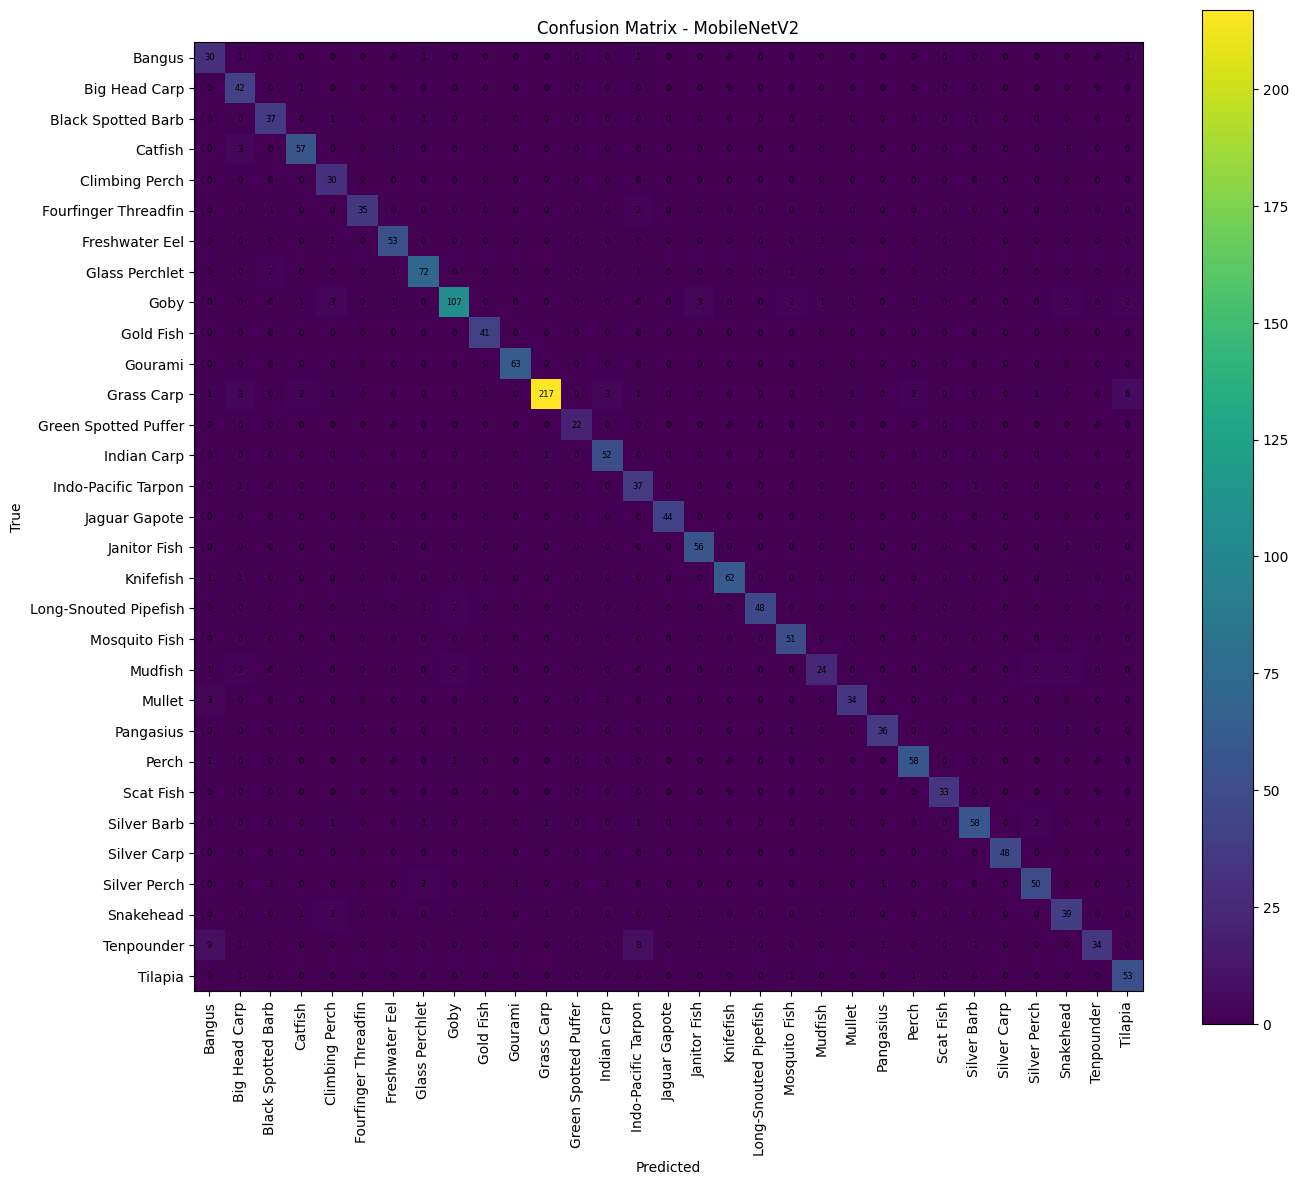

In [ ]:
# === Cell: Confusion Matrix + SAVE ke outputs/figures ===
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

os.makedirs("../outputs/figures", exist_ok=True)

cm = confusion_matrix(y_true, y_pred)

# pilih: True = normalisasi per baris (lebih enak untuk banyak kelas), False = count asli
normalize = False

if normalize:
    cm_show = cm.astype(np.float32) / (cm.sum(axis=1, keepdims=True) + 1e-12)
    title = "Confusion Matrix - MobileNetV2 (Normalized)"
    out_path = "../outputs/figures/confusion_matrix_mobilenetv2_normalized.png"
else:
    cm_show = cm
    title = "Confusion Matrix - MobileNetV2"
    out_path = "../outputs/figures/confusion_matrix_mobilenetv2.png"

plt.figure(figsize=(14, 12))
plt.imshow(cm_show)
plt.title(title)
plt.colorbar()

plt.xticks(range(len(class_names)), class_names, rotation=90)
plt.yticks(range(len(class_names)), class_names)

# tulis angka di tiap kotak (biar mirip contoh temanmu)
if len(class_names) <= 40:
    for i in range(cm_show.shape[0]):
        for j in range(cm_show.shape[1]):
            txt = f"{cm_show[i, j]:.2f}" if normalize else str(int(cm_show[i, j]))
            plt.text(j, i, txt, ha="center", va="center", fontsize=6)

plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()


plt.savefig(out_path, dpi=200, bbox_inches="tight")
print("Saved:", os.path.abspath(out_path))

plt.show()


Confusion matrix ini menunjukkan perbandingan **label asli (sumbu Y / True)** vs **label prediksi model (sumbu X / Predicted)** untuk semua kelas ikan.

- **Kotak diagonal (dari kiri-atas ke kanan-bawah)** berisi prediksi yang benar.  
  Di gambar ini diagonalnya dominan dan nilainya besar artinya model **mengklasifikasikan sebagian besar gambar dengan tepat**.
- **Kotak di luar diagonal** adalah kesalahan (misclassification).  
  Karena kebanyakan nilainya kecil (banyak yang 0 atau 1), berarti **jumlah kesalahan relatif sedikit**.
- Warna semakin terang = jumlah sampel semakin banyak.  
  Contoh kelas seperti **Grass Carp** terlihat sangat terang di diagonal (mis. 217) → ini menandakan kelas tersebut punya **support besar** dan banyak yang terprediksi benar.

Kesimpulan: pola diagonal yang kuat + sedikit nilai di luar diagonal menunjukkan model **berperforma tinggi dan konsisten**, dengan kebingungan hanya terjadi pada beberapa pasangan kelas tertentu.


## **Plot training curves**

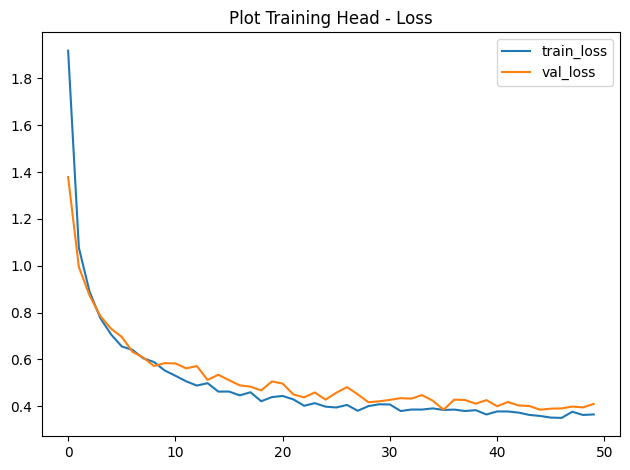

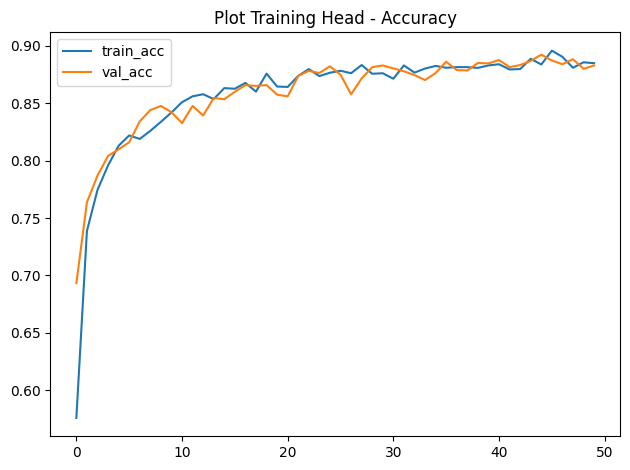

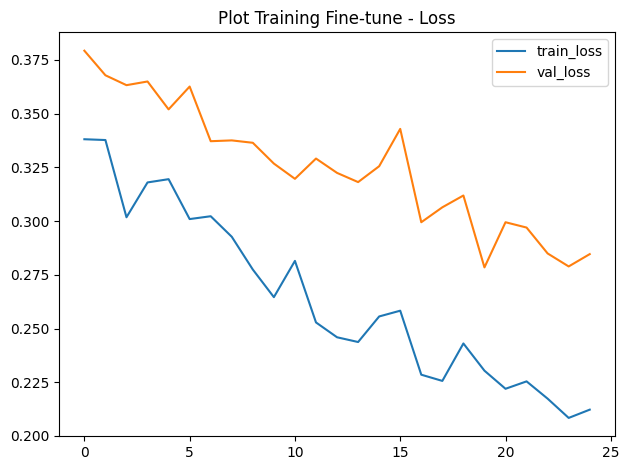

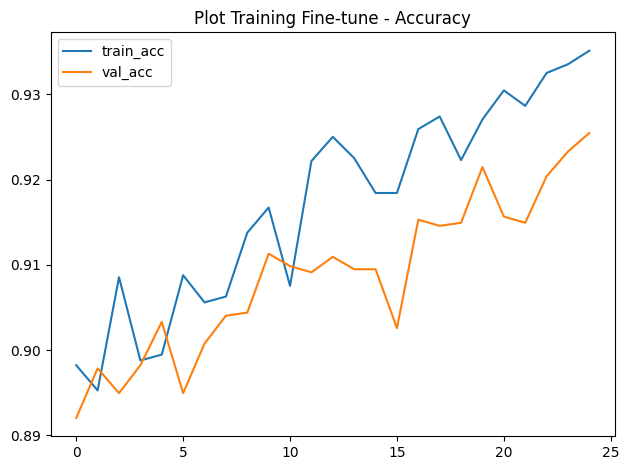

Saved curves to: d:\CNN_FishImgDataset\outputs\figures


In [46]:
import os
import matplotlib.pyplot as plt

os.makedirs("../outputs/figures", exist_ok=True)

def plot_hist_save(hist, title, prefix):
    # Loss
    plt.figure()
    plt.plot(hist["train_loss"], label="train_loss")
    plt.plot(hist["val_loss"], label="val_loss")
    plt.legend()
    plt.title(title + " - Loss")
    plt.tight_layout()
    plt.savefig(f"../outputs/figures/{prefix}_loss.png", dpi=200, bbox_inches="tight")
    plt.show()

    # Accuracy
    plt.figure()
    plt.plot(hist["train_acc"], label="train_acc")
    plt.plot(hist["val_acc"], label="val_acc")
    plt.legend()
    plt.title(title + " - Accuracy")
    plt.tight_layout()
    plt.savefig(f"../outputs/figures/{prefix}_acc.png", dpi=200, bbox_inches="tight")
    plt.show()

plot_hist_save(mb_hist1, "Plot Training Head", "PlotTraining_Head")
plot_hist_save(mb_hist2, "Plot Training Fine-tune", "PlotTraining_Finetune")

print("Saved curves to:", os.path.abspath("../outputs/figures"))


### Plot Training Fine-tune — Accuracy

Grafik ini menunjukkan perkembangan **akurasi** selama proses **fine-tuning MobileNetV2**.
- **Garis biru (train_acc)**: akurasi pada data *training* terus meningkat hingga sekitar **0.93+**, artinya model makin “hafal” pola data latih.
- **Garis oranye (val_acc)**: akurasi pada data *validasi* juga naik hingga sekitar **0.92–0.93**, menandakan kemampuan generalisasi ikut membaik.
- Karena **train_acc > val_acc** tetapi selisihnya **tidak terlalu jauh**, model terlihat belajar dengan baik tanpa overfitting yang parah.
- Fluktuasi kecil pada **val_acc** itu normal saat fine-tuning (terutama karena augmentasi dan data per kelas tidak selalu seimbang).

### Plot Training Fine-tune — Loss

Grafik ini menunjukkan perubahan **loss** selama proses **fine-tuning MobileNetV2**.
- **Garis biru (train_loss)** terus menurun hingga sekitar **0.21**, artinya model semakin baik meminimalkan error pada data training.
- **Garis oranye (val_loss)** juga menurun (dari ~0.38 ke ~0.28–0.29), menandakan performa pada data validasi ikut membaik.
- Karena **val_loss cenderung turun** dan tidak “naik terus” di akhir, ini tanda **overfitting tidak parah**.
- Ada sedikit **fluktuasi val_loss** (naik-turun) yang wajar terjadi saat fine-tuning, terutama karena augmentasi dan variasi data per kelas.

### Plot Training Head — Accuracy

Grafik ini menunjukkan perkembangan **akurasi** saat training **MobileNetV2 (pretrained) dengan backbone di-freeze**, sehingga yang dilatih hanya **classifier head**.
- Di awal, akurasi naik cepat (dari ~0.58 → >0.80), artinya **head cepat belajar memetakan fitur pretrained ke kelas ikan**.
- Setelah sekitar epoch 15–20, kurva mulai **stabil/plateau** di sekitar **0.88–0.89** untuk train dan val.
- **Train_acc dan val_acc sangat dekat** sepanjang training → ini tanda **generalization bagus** dan **overfitting kecil** (model tidak “jago di train saja”).
- Karena sudah plateau, peningkatan berikutnya biasanya perlu **fine-tuning (unfreeze beberapa layer terakhir)** agar fitur backbone ikut menyesuaikan dengan dataset ikan.
### Plot Training Head — Loss

Grafik ini menunjukkan perubahan **loss** saat training **MobileNetV2 pretrained dengan backbone di-freeze** (yang dilatih hanya **classifier head**).
- Di awal epoch, **train_loss dan val_loss turun drastis** → model cepat belajar dari fitur pretrained (konvergensi cepat).
- Setelah sekitar epoch 10–15, penurunan loss mulai **melambat dan stabil** (plateau) di kisaran ~0.35–0.45.
- **Jarak train_loss vs val_loss kecil** dan polanya mirip → tanda **overfitting rendah** dan model cukup general untuk data validasi.
- Karena loss sudah cenderung plateau, peningkatan performa berikutnya biasanya perlu **fine-tuning** (unfreeze beberapa layer terakhir) supaya fitur backbone ikut menyesuaikan dengan dataset ikan.



## **Grad-CAM**

In [27]:
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, inp, out):
        self.activations = out

    def _backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0]

    def __call__(self, x, class_idx=None):
        self.model.eval()
        x = x.to(device)

        logits = self.model(x)
        if class_idx is None:
            class_idx = logits.argmax(1).item()

        self.model.zero_grad(set_to_none=True)
        score = logits[:, class_idx]
        score.backward(retain_graph=True)

        grads = self.gradients
        acts = self.activations
        weights = grads.mean(dim=(2,3), keepdim=True)

        cam = (weights * acts).sum(dim=1, keepdim=True)
        cam = F.relu(cam).squeeze(0).squeeze(0)

        cam = cam.detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        return cam


## **Grad-CAM overlay** 

Saved: d:\CNN_FishImgDataset\outputs\figures\gradcam_grid.png


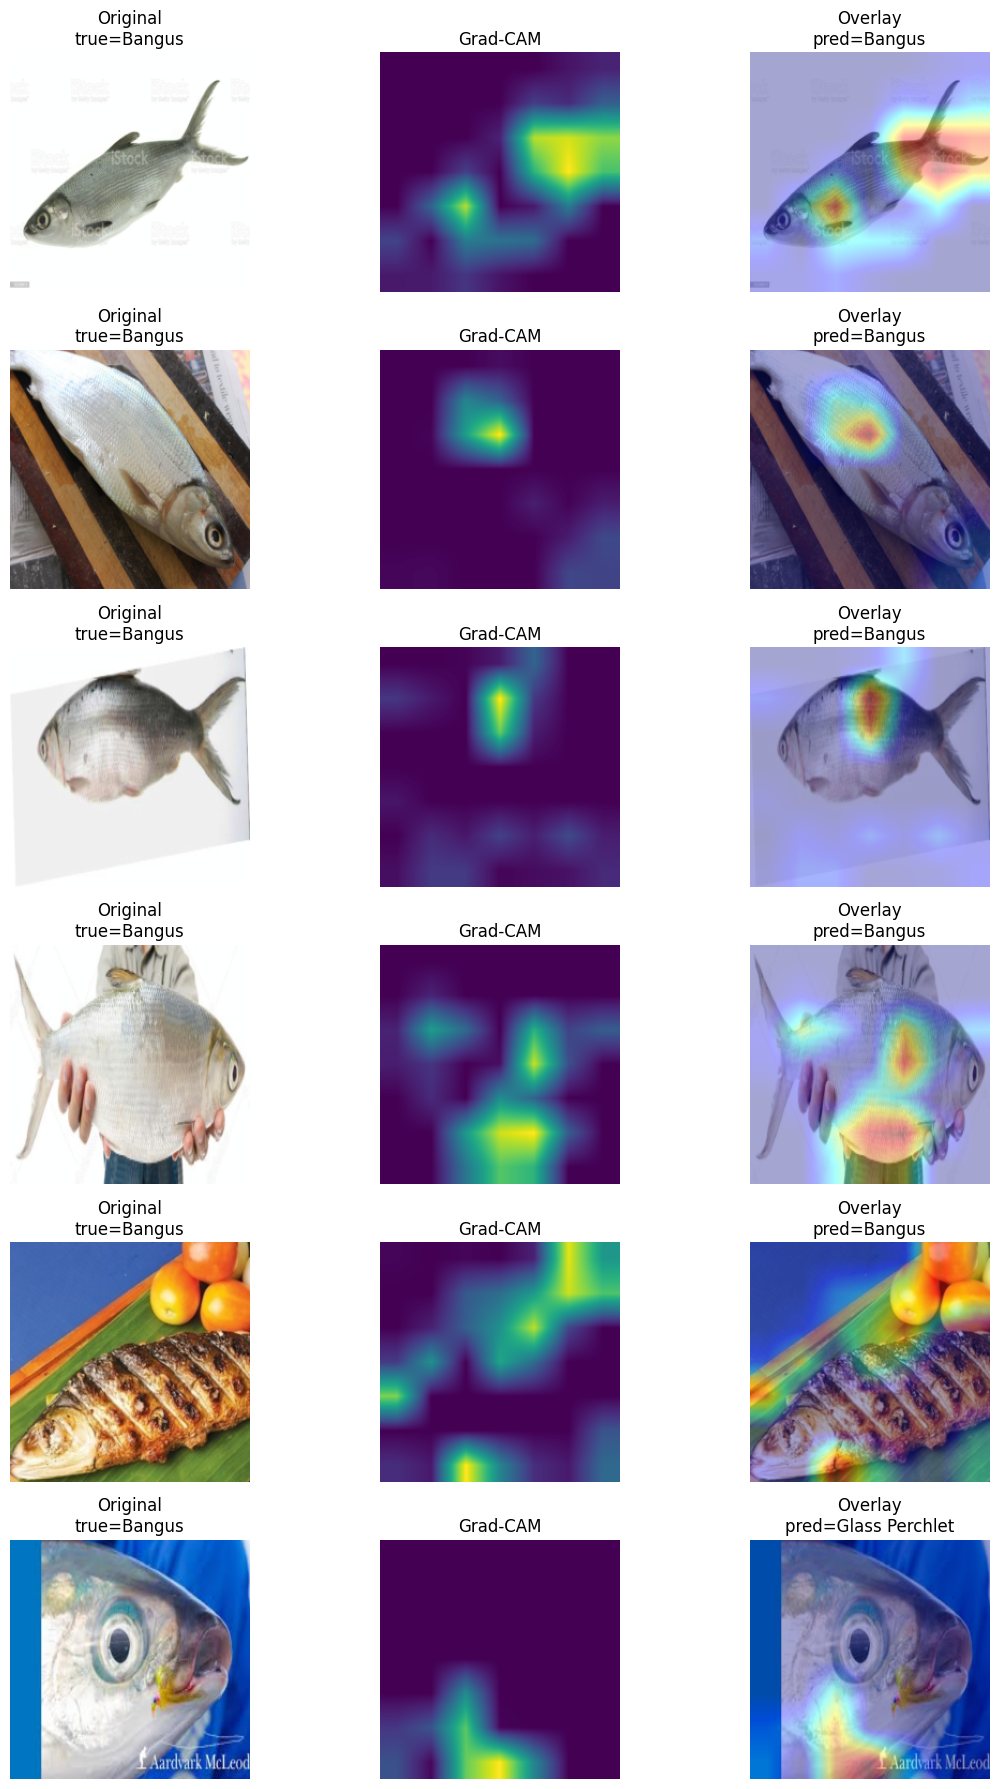

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

def show_gradcam_examples(model, loader, gradcam, class_names, n=6, save_path="../outputs/figures/gradcam_grid.png"):
    model.eval()
    images, labels = next(iter(loader))
    n = min(n, images.size(0))

    plt.figure(figsize=(12, 3*n))

    mean = np.array([0.485,0.456,0.406])
    std  = np.array([0.229,0.224,0.225])

    for i in range(n):
        img = images[i:i+1]
        true_label = labels[i].item()

        with torch.no_grad():
            logits = model(img.to(device))
        pred_label = logits.argmax(1).item()

        cam = gradcam(img, class_idx=pred_label)

        # unnormalize display
        img_np = images[i].permute(1,2,0).numpy()
        img_np = np.clip(img_np * std + mean, 0, 1)

        cam_resized = cv2.resize(cam, (img_np.shape[1], img_np.shape[0]))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
        overlay = np.clip(0.65 * img_np + 0.35 * heatmap, 0, 1)

        # plot row i
        plt.subplot(n, 3, 3*i + 1)
        plt.imshow(img_np)
        plt.title(f"Original\ntrue={class_names[true_label]}")
        plt.axis("off")

        plt.subplot(n, 3, 3*i + 2)
        plt.imshow(cam_resized)
        plt.title("Grad-CAM")
        plt.axis("off")

        plt.subplot(n, 3, 3*i + 3)
        plt.imshow(overlay)
        plt.title(f"Overlay\npred={class_names[pred_label]}")
        plt.axis("off")

    plt.tight_layout()

    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=200, bbox_inches="tight")
    print("Saved:", os.path.abspath(save_path))

    plt.show()


show_gradcam_examples(mobilenet, test_loader, gradcam, class_names, n=6, save_path="../outputs/figures/gradcam_grid.png")


Beberapa sampel mengalami salah klasifikasi (misalnya, label asli Bangus diprediksi sebagai Glass Perchlet). Grad-CAM menunjukkan bahwa model hanya berfokus pada area terbatas (seperti di dekat bagian kepala, watermark, atau latar belakang) dan bukan pada seluruh tubuh ikan. Hal ini mengindikasikan bahwa prediksi kemungkinan besar dipengaruhi oleh petunjuk kontekstual dan visibilitas parsial, yang menegaskan pentingnya kualitas dataset serta augmentasi yang kuat (robust augmentation).

### **Ambil y_true + y_score (probabilities) dari test_loader**

In [37]:
import numpy as np
import torch

@torch.no_grad()
def predict_scores(model, loader):
    model.eval()
    y_true_list, y_score_list = [], []
    for x, y in loader:
        x = x.to(device)
        logits = model(x)                       # [B, C]
        probs = torch.softmax(logits, dim=1)    # [B, C]
        y_true_list.append(y.numpy())
        y_score_list.append(probs.cpu().numpy())
    y_true = np.concatenate(y_true_list)
    y_score = np.concatenate(y_score_list)
    return y_true, y_score

y_true, y_score = predict_scores(mobilenet, test_loader)
print("y_true:", y_true.shape, "y_score:", y_score.shape)


y_true: (1760,) y_score: (1760, 31)


## **Plot ROC top 5 classes by AUC**

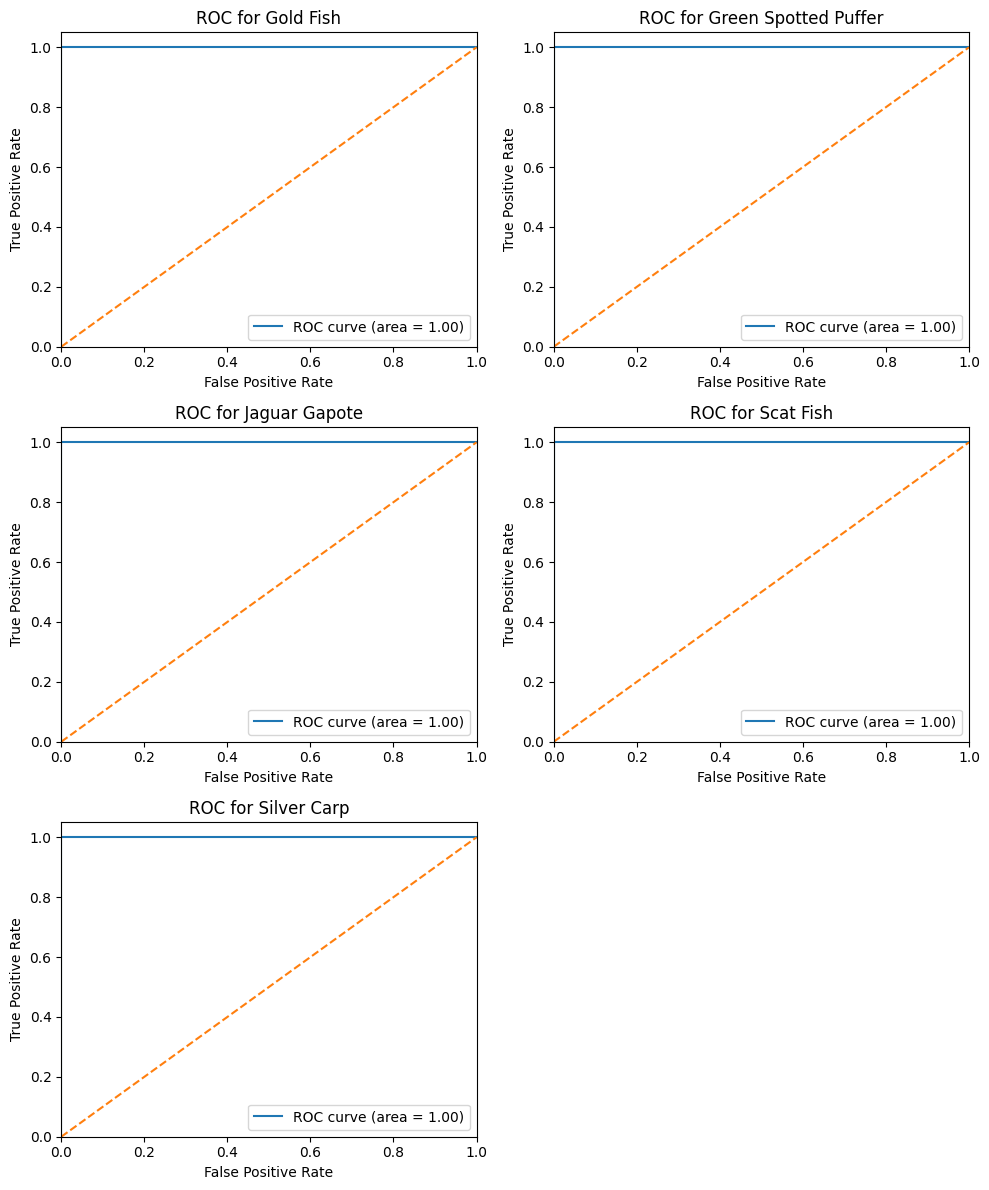

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_topk_roc(y_true, y_score, class_names, top_k=5):
    n_classes = len(class_names)

    # Binarize true labels: shape (N, C)
    y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

    # Hitung AUC per kelas (One-vs-Rest)
    aucs = []
    roc_data = []

    for c in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, c], y_score[:, c])
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        roc_data.append((c, fpr, tpr, roc_auc))

    # ambil top-k
    top = sorted(roc_data, key=lambda x: x[3], reverse=True)[:top_k]

    # plot grid 2 kolom
    rows = int(np.ceil(top_k / 2))
    plt.figure(figsize=(10, 4*rows))

    for i, (c, fpr, tpr, roc_auc) in enumerate(top, 1):
        plt.subplot(rows, 2, i)
        plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC for {class_names[c]}")
        plt.legend(loc="lower right")

    plt.tight_layout()
    os.makedirs("../outputs/figures", exist_ok=True)
    plt.tight_layout()
    plt.savefig("../outputs/figures/roc_top5.png", dpi=200, bbox_inches="tight")
    plt.show()

plot_topk_roc(y_true, y_score, class_names, top_k=5)


Gambar ini menampilkan **ROC curve per kelas (one-vs-rest)** untuk 5 kelas ikan dengan performa terbaik.
- **Garis biru** = ROC model untuk kelas tersebut (True Positive Rate (TPR)) vs False Positive (Rate)).
- **Garis putus-putus oranye** = baseline model acak (AUC = 0.5). Semakin jauh di atas garis ini, semakin baik.
- Semua plot menunjukkan **AUC = 1.00** → artinya untuk masing-masing kelas ini, model **mampu memisahkan “kelas ini” vs “bukan kelas ini” dengan sempurna** pada data test (hampir tidak ada false positive maupun false negative).
- ROC yang “nempel” ke **sisi kiri-atas** menandakan **TPR tinggi** (banyak benar terdeteksi) dengan **FPR sangat rendah** (sangat sedikit salah deteksi).
